# Project: Image Classification and Regression - Marion Favre d'Echallens

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.patches as patches
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten

In [60]:
#Keras modules
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential 
from keras.layers import Dense, Activation
from keras.optimizers import SGD, Adam

Useful functions and example

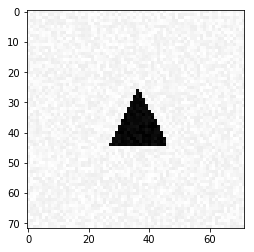

In [5]:
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


#### 3) SIMPLE CLASSIFICATION: RECTANGLE(0), DISK(1), TRIANGLE(2)

##### a) STOCHASTIC GRADIENT OPTIMIZER

In [6]:
[X_train, Y_train] = generate_dataset_classification(300, 20) 
# Convert labels to categorical one-hot encoding
Y_train = np_utils.to_categorical(Y_train, num_classes=3)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [22]:
#Stochastic Gradient Descent 
# For a three-class classification problem
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(5184,)))
model.add(Dense(3, activation='softmax'))
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.5, nesterov=False)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,metrics=['accuracy']) 

#training the model  
model.fit(X_train, Y_train, epochs=10, batch_size=32)

Epoch 1/10
300/300 [==============================] - 1s 3ms/step - loss: 1.8465 - acc: 0.3600
Epoch 2/10
300/300 [==============================] - 0s 500us/step - loss: 0.9237 - acc: 0.5667
Epoch 3/10
300/300 [==============================] - 0s 550us/step - loss: 0.7963 - acc: 0.6267
Epoch 4/10
300/300 [==============================] - 0s 626us/step - loss: 0.7677 - acc: 0.6333
Epoch 5/10
300/300 [==============================] - 0s 593us/step - loss: 0.6066 - acc: 0.7500
Epoch 6/10
300/300 [==============================] - 0s 563us/step - loss: 0.5235 - acc: 0.7600
Epoch 7/10
300/300 [==============================] - 0s 550us/step - loss: 0.4591 - acc: 0.7900
Epoch 8/10
300/300 [==============================] - 0s 566us/step - loss: 0.4824 - acc: 0.7867
Epoch 9/10
300/300 [==============================] - 0s 646us/step - loss: 0.4240 - acc: 0.7767
Epoch 10/10
300/300 [==============================] - 0s 546us/step - loss: 0.3491 - acc: 0.8700


In [23]:
#testing
X_test = generate_a_disk() #classe 1
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test,batch_size=32, verbose=0)

array([[0., 1., 0.]], dtype=float32)

##### B) ADAM OPTIMIZER

In [11]:
# For a three-class classification problem
model_A = Sequential()
model_A.add(Dense(3, activation='softmax',input_shape = (5184,)))
model_A.compile(loss='categorical_crossentropy', 
              optimizer='adam',metrics=['accuracy']) 
#training the model
model_A.fit(X_train, Y_train, epochs=10, batch_size=32)


Epoch 1/10
300/300 [==============================] - 1s 3ms/step - loss: 1.3235 - acc: 0.4600
Epoch 2/10
300/300 [==============================] - 0s 450us/step - loss: 0.7039 - acc: 0.6533
Epoch 3/10
300/300 [==============================] - 0s 363us/step - loss: 0.4856 - acc: 0.7667
Epoch 4/10
300/300 [==============================] - 0s 406us/step - loss: 0.3914 - acc: 0.8233
Epoch 5/10
300/300 [==============================] - 0s 433us/step - loss: 0.2960 - acc: 0.9300
Epoch 6/10
300/300 [==============================] - 0s 500us/step - loss: 0.2759 - acc: 0.9233
Epoch 7/10
300/300 [==============================] - 0s 736us/step - loss: 0.2948 - acc: 0.8667
Epoch 8/10
300/300 [==============================] - 0s 660us/step - loss: 0.2132 - acc: 0.9533
Epoch 9/10
300/300 [==============================] - 0s 526us/step - loss: 0.2317 - acc: 0.9167
Epoch 10/10
300/300 [==============================] - 0s 650us/step - loss: 0.2638 - acc: 0.8867 0s - loss: 0.2291 - acc: 0.906


In [24]:
#testing
X_test = generate_a_disk() #classe 1
X_test = X_test.reshape(1, X_test.shape[0])
model_A.predict(X_test,batch_size=32, verbose=0)

array([[0., 1., 0.]], dtype=float32)

Adam optimizer seems to have a better accurracy than the SGD optimizer.

### 4) VISUALIZATION OF THE SOLUTION

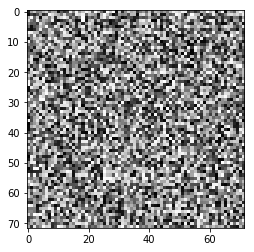

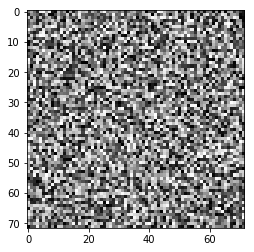

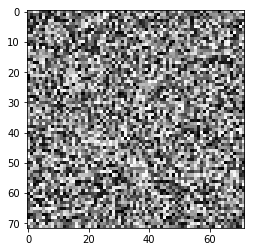

In [25]:
# SGD optimizer
W = model.layers[0].get_weights()
plt.imshow(W[0][:,0].reshape(72,72), cmap='gray')
plt.show()
plt.imshow(W[0][:,1].reshape(72,72), cmap='gray')
plt.show()
plt.imshow(W[0][:,2].reshape(72,72), cmap='gray')
plt.show()

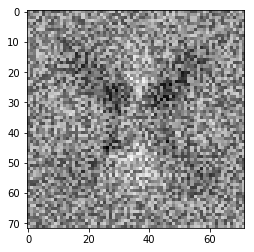

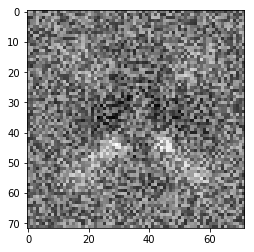

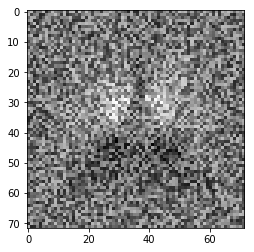

In [26]:
# Adam optimizer
W = model_A.layers[0].get_weights()
plt.imshow(W[0][:,0].reshape(72,72), cmap='gray')
plt.show()
plt.imshow(W[0][:,1].reshape(72,72), cmap='gray')
plt.show()
plt.imshow(W[0][:,2].reshape(72,72), cmap='gray')
plt.show()

### 5) MORE DIFFICULT CLASSIFICATION PROBLEM

In [40]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
Y_train = np_utils.to_categorical(Y_train, num_classes=3)


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [32]:
#Stochastic Gradient Descent 
# For a three-class classification problem
model = Sequential()
model.add(Dense(168, activation='relu', input_shape = (5184,)))
model.add(Dense(3, activation='softmax'))
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.5, nesterov=False)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,metrics=['accuracy']) 

#training the model  
model.fit(X_train, Y_train, epochs=10, batch_size=64)

Epoch 1/10
300/300 [==============================] - 2s 5ms/step - loss: 4.0787 - acc: 0.3100
Epoch 2/10
300/300 [==============================] - 0s 2ms/step - loss: 1.1330 - acc: 0.3800
Epoch 3/10
300/300 [==============================] - 0s 1ms/step - loss: 1.0837 - acc: 0.3967
Epoch 4/10
300/300 [==============================] - 0s 693us/step - loss: 1.0811 - acc: 0.4000
Epoch 5/10
300/300 [==============================] - 0s 610us/step - loss: 1.0724 - acc: 0.4067
Epoch 6/10
300/300 [==============================] - 0s 520us/step - loss: 1.0702 - acc: 0.4867
Epoch 7/10
300/300 [==============================] - 0s 680us/step - loss: 1.0684 - acc: 0.3900
Epoch 8/10
300/300 [==============================] - 0s 476us/step - loss: 1.0551 - acc: 0.4033
Epoch 9/10
300/300 [==============================] - 0s 576us/step - loss: 1.0410 - acc: 0.4467
Epoch 10/10
300/300 [==============================] - 0s 510us/step - loss: 1.0160 - acc: 0.5367


In [44]:
[X_test, Y_test] = generate_test_set_classification()

#loss and accuracy
model.evaluate(X_test, Y_test) #SGD optimizer

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300/300 [==============================] - 0s 523us/step


[1.0247867552439371, 0.46333333412806194]

In [34]:
# For a three-class classification problem
model_A = Sequential()
model_A.add(Dense(3, activation='softmax',input_shape = (5184,)))
model_A.compile(loss='categorical_crossentropy', 
              optimizer='adam',metrics=['accuracy']) 
#training the model
model_A.fit(X_train, Y_train, epochs=10, batch_size=32)

Epoch 1/10
300/300 [==============================] - 1s 3ms/step - loss: 2.2492 - acc: 0.3567
Epoch 2/10
300/300 [==============================] - 0s 386us/step - loss: 1.6901 - acc: 0.3667
Epoch 3/10
300/300 [==============================] - 0s 280us/step - loss: 1.2031 - acc: 0.4600
Epoch 4/10
300/300 [==============================] - 0s 350us/step - loss: 1.0345 - acc: 0.4300
Epoch 5/10
300/300 [==============================] - 0s 297us/step - loss: 0.9575 - acc: 0.4800
Epoch 6/10
300/300 [==============================] - 0s 306us/step - loss: 0.9091 - acc: 0.5167
Epoch 7/10
300/300 [==============================] - 0s 340us/step - loss: 1.0132 - acc: 0.5067
Epoch 8/10
300/300 [==============================] - 0s 313us/step - loss: 1.0550 - acc: 0.4967
Epoch 9/10
300/300 [==============================] - 0s 380us/step - loss: 1.0967 - acc: 0.4733
Epoch 10/10
300/300 [==============================] - 0s 283us/step - loss: 1.0109 - acc: 0.5000


In [35]:
model_A.evaluate(X_test, Y_test) #Adam optimizer

300/300 [==============================] - 0s 923us/step


[1.2037010113398234, 0.4233333325386047]

Previous models are less efficient with the new training set, Adam optimizer remains better than SGD optimizer.

In [41]:
#creating a new model  
X_trainr=X_train.reshape(X_train.shape[0],72,72,1)
print(X_trainr.shape)
Y_trainr=Y_train
print(Y_trainr.shape)

(300, 72, 72, 1)
(300, 3)


In [53]:
##Convolution2D
model2 = Sequential() 
model2.add(Conv2D(16, (5,5), activation='relu',input_shape=(72,72,1)))
model2.add(Dropout(0.25))
print(model2.output_shape)

model2.add(MaxPooling2D(pool_size =(2,2)))
print(model2.output_shape)
model2.add(Flatten())
print(model2.output_shape)
model2.add(Dense(3,activation='softmax'))
print(model2.output_shape)


model2.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model2.fit(X_trainr, Y_trainr, epochs=20, batch_size=32)

(None, 68, 68, 16)
(None, 34, 34, 16)
(None, 18496)
(None, 3)
Epoch 1/20
300/300 [==============================] - 5s 17ms/step - loss: 1.3642 - acc: 0.3433
Epoch 2/20
300/300 [==============================] - 5s 18ms/step - loss: 0.9229 - acc: 0.6300
Epoch 3/20
300/300 [==============================] - 5s 16ms/step - loss: 0.8241 - acc: 0.7100
Epoch 4/20
300/300 [==============================] - 5s 15ms/step - loss: 0.7467 - acc: 0.7500
Epoch 5/20
300/300 [==============================] - 5s 17ms/step - loss: 0.6744 - acc: 0.7967
Epoch 6/20
300/300 [==============================] - 4s 14ms/step - loss: 0.6131 - acc: 0.7900
Epoch 7/20
300/300 [==============================] - 4s 15ms/step - loss: 0.5951 - acc: 0.8100
Epoch 8/20
300/300 [==============================] - 4s 13ms/step - loss: 0.5412 - acc: 0.8367
Epoch 9/20
300/300 [==============================] - 4s 14ms/step - loss: 0.4980 - acc: 0.8600
Epoch 10/20
300/300 [==============================] - 4s 14ms/step - loss

In [54]:
X_testr = X_test.reshape(X_test.shape[0],72,72,1)
print(X_testr.shape)

(300, 72, 72, 1)


In [55]:
model2.evaluate(X_testr, Y_test)

300/300 [==============================] - 2s 7ms/step


[0.6428067207336425, 0.7200000007947286]

The value of the lost function when using the deep network is: 0.64. 

### 6) A REGRESSION PROBLEM

In [56]:
#normalize vertices
def normer(Y):
    for i in range(len(Y)):
        a = math.sqrt(Y[i,0]**2 + Y[i,1]**2)
        b = math.sqrt(Y[i,2]**2 + Y[i,3]**2)
        c = math.sqrt(Y[i,4]**2 + Y[i,5]**2)
        Y[i,:]=[Y[i,0]/a,Y[i,1]/a,Y[i,2]/b,Y[i,3]/b,Y[i,4]/c,Y[i,5]/c]
    return Y


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


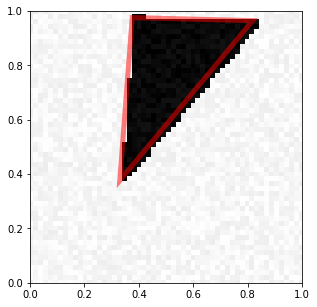

In [57]:
[X_train, Y_train] = generate_dataset_regression(300, 20)
visualize_prediction(X_train[0], Y_train[0])

In [58]:
X_train2 = X_train.reshape(X_train.shape[0], 72, 72, 1)
Y_train = normer(Y_train)

In [62]:
model_r = Sequential()
model_r.add(Conv2D(16, (5, 5), activation='relu', input_shape=(72, 72, 1)))
model_r.add(MaxPooling2D(pool_size=(2, 2)))
model_r.add(Conv2D(8, (5, 5), activation='relu', input_shape=(72, 72, 1)))
model_r.add(MaxPooling2D(pool_size=(2, 2)))
model_r.add(Flatten()) 
model_r.add(Dense(256, activation='relu')) 
model_r.add(Dense(128, activation='relu')) 
model_r.add(Dense(6)) 

adam = Adam(lr=1e-3, beta_1=0.5, beta_2=0.5, epsilon=0.001, decay=0.1)
model_r.compile(loss='mean_squared_error', 
              optimizer=adam,metrics = ['accuracy'])
model_r.fit(X_train2, Y_train, epochs=20, batch_size=64)


Epoch 1/20
300/300 [==============================] - 3s 11ms/step - loss: 0.2246
Epoch 2/20
300/300 [==============================] - 2s 6ms/step - loss: 0.0869
Epoch 3/20
300/300 [==============================] - 2s 6ms/step - loss: 0.0822
Epoch 4/20
300/300 [==============================] - 2s 8ms/step - loss: 0.0787
Epoch 5/20
300/300 [==============================] - 2s 6ms/step - loss: 0.0755
Epoch 6/20
300/300 [==============================] - 2s 6ms/step - loss: 0.0746
Epoch 7/20
300/300 [==============================] - 2s 6ms/step - loss: 0.0742
Epoch 8/20
300/300 [==============================] - 2s 6ms/step - loss: 0.0722
Epoch 9/20
300/300 [==============================] - 2s 7ms/step - loss: 0.0724
Epoch 10/20
300/300 [==============================] - 2s 7ms/step - loss: 0.0699
Epoch 11/20
300/300 [==============================] - 2s 7ms/step - loss: 0.0686
Epoch 12/20
300/300 [==============================] - 3s 9ms/step - loss: 0.0682
Epoch 13/20
300/300 [===

In [63]:
[X_test, Y_test] = generate_test_set_regression()
X_test = X_test.reshape(X_test.shape[0], 72, 72, 1)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [64]:
Y_test = normer(Y_test)
model_r.evaluate(X_test, Y_test)

300/300 [==============================] - 1s 4ms/step


0.07040431290864944

### 7) IMAGE DENOISING